# Evaluating definite integrals using `TaylorIntegration.jl`

The aim of this example is to show that we can evaluate definite integrals of the form 

$$
I(x) = \int_{x_0}^xf(t)\mathrm{d} t
$$

for a large class of differentiable integrand functions $f$, to within machine epsilon precision, using `TaylorIntegration.jl`. The trick is to translate the definite integral problem to an initial value problem for an explicit ODE, thanks to the fundamental theorem of calculus.

## Case study: $I(x)=\frac{2}{\sqrt{\pi}}\int_0^x \exp(-[g(t)]^2) dt$

## 1. $g(t)=t$

In general, if we want to evaluate the [__error function__](https://en.wikipedia.org/wiki/Error_function) integral $I(x)=\frac{2}{\sqrt{\pi}}\int_0^x \exp(-[g(t)]^2) dt$ using `TaylorIntegration.jl`, then we may proceed as follows. Essentially: first define a suitable ODE system equivalent to the definite integral problem at hand, and then integrate it. 

Indeed, by the fundamental theorem of calculus we have

$$
I'(x) =\frac{2}{\sqrt{\pi}}\exp(-[g(x)]^2)
$$


where the prime $'$ denotes differentiation with respect to $x$. Therefore, we reinterpret $I(x)$ as the solution of the initial value problem defined by the ODE

$$
\frac{dI}{dx} = \frac{2}{\sqrt{\pi}}\exp(-[g(x)]^2)
$$

subject to the initial condition $I(0)=0$. We will integrate this ODE in order to evaluate $I(x)$.

The only packages that we need to load are:

In [1]:
using TaylorIntegration, Plots
pyplot()

Plots.PyPlotBackend()

This is the ODE representation of the integral we are interested in, $I(x)$:

In [2]:
g(x) = x

f(t, x) = (2/sqrt(pi))*exp(-g(t)^2)

f (generic function with 1 method)

The parameters we will use for the Taylor integration are:

In [3]:
x0 = 0.0 #the initial value of the independent variable; in this case, x
xmax = 10.0 #the final value of the independent variable; in this case, x
I0 = 0.0 #the initial condition for I
order = 25 #the order of the Taylor expansions
abstol = 1e-20 #the absolute local error tolerance

1.0e-20

The initial conditions are:

In [4]:
I0

0.0

Then, we proceed to integrate:

In [5]:
@time xv, Iv = taylorinteg(f, I0, x0, xmax, order, abstol, maxsteps=5000);

  0.344153 seconds (149.65 k allocations: 8.082 MiB, 2.65% gc time)


The final $t$, and $x$ values are (remember that the first column of `Iv` corresponds to the independent variable):

In [6]:
xv[end], Iv[end]

(10.0, 1.0)

It seems that the integration has already converged. For clarity, let's print `Iv`:

In [7]:
Iv

18-element SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}:
 0.0     
 0.427483
 0.729112
 0.896165
 0.968871
 0.993069
 0.998962
 0.999907
 0.999994
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     

For even more clarity, let's print `diff(Iv)`:

In [8]:
diff(Iv)

17-element Array{Float64,1}:
 0.427483   
 0.301628   
 0.167054   
 0.0727055  
 0.0241986  
 0.00589268 
 0.000945083
 8.71028e-5 
 5.58253e-6 
 2.20794e-7 
 4.69196e-9 
 4.42399e-11
 1.38112e-13
 0.0        
 0.0        
 0.0        
 0.0        

So, after about the thirteenth integration step, $I(x)$ has already converged. Now, how does $I(x)$ look as a function of $x$?


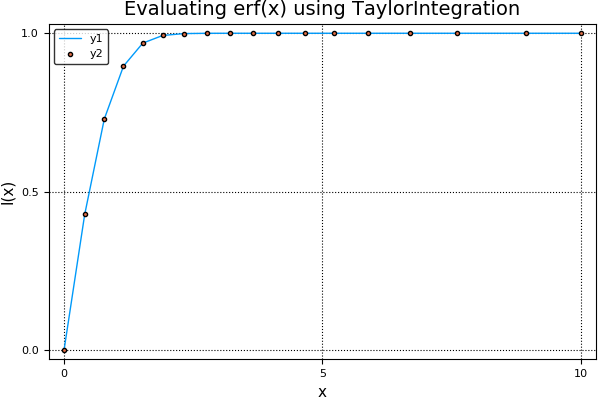

In [9]:
plot(

xv, Iv,
xaxis = "x",
yaxis = "I(x)",
title = "Evaluating erf(x) using TaylorIntegration"

)

scatter!(xv, Iv, ms=3.0)

Looks great; but, how do these values actually compare to $\mathrm{erf}$? Well, let's plot the absolute difference between our values for $I(x)$ and $\mathrm{erf}(x)$, in units of the machine epsilon, as a function of $x$:


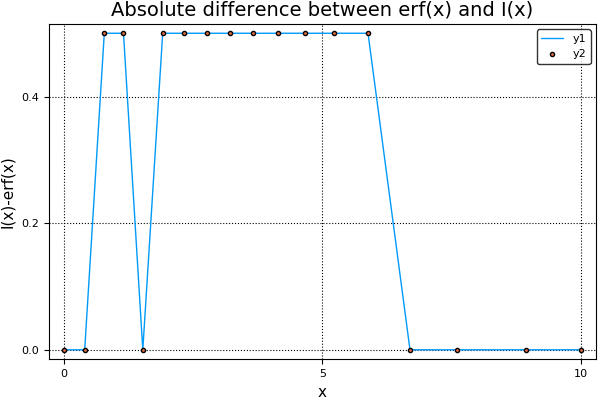

In [10]:
plot(

xv, (Iv-erf.(xv))/eps(),
xaxis = "x",
yaxis = "I(x)-erf(x)",
title = "Absolute difference between erf(x) and I(x)"

)

scatter!(xv, (Iv-erf.(xv))/eps(), ms=3.0)

### The error is at most half times `eps()` at each time step!!!!

## 2. $g(t)=\cos{t}$

When $g(x)=\cos{x}$, if we ignore the factor $\frac{2}{\sqrt{\pi}}$, then the definite integral reduces to

$$
I(x)=\int_0^x \exp(-\cos^2(t)) dt
$$

We end up with the following system:
$$
\begin{equation}
        \frac{dI}{dx} = \exp(-\cos^2(x))
\end{equation}
$$
subject to the initial condition $I(0)=0$.

In [11]:
G(x) = cos(x)

f2(t, x) = (2/sqrt(pi))*exp(-G(t)^2)

f2 (generic function with 1 method)

We will integrate from $x=0$ to $x=10$:

In [12]:
x02 = 0.0 #the initial value of the independent variable; in this case, x
xmax2 = 10.0 #the final value of the independent variable; in this case, x
I02 = 0.0 #the initial condition for I, J, x
order2 = 25 #the order of the Taylor expansions
abstol2 = 1e-20 #the absolute local error tolerance

1.0e-20

In [13]:
I02

0.0

Next, we perform the Taylor integration:

In [14]:
@time xv2, Iv2 = taylorinteg(f2, I02, x02, xmax2, order2, abstol2, maxsteps=5000);

  0.057088 seconds (30.73 k allocations: 2.478 MiB)


In this case, we don't have an explicit expression to evaluate the definite integral! Nevertheless, we can plot $I(x)$ as a function of $x$:


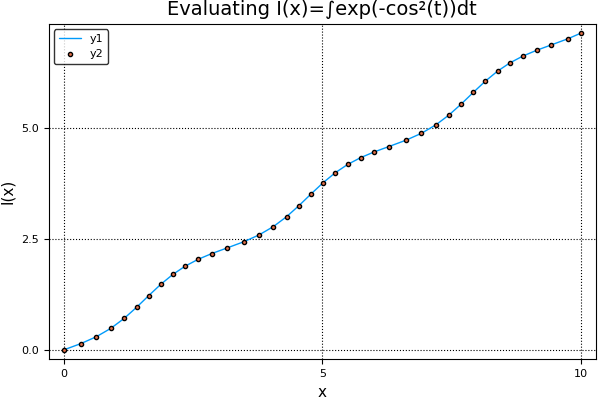

In [15]:
plot(

xv2, Iv2,
xaxis = "x",
yaxis = "I(x)",
title = "Evaluating I(x)=∫exp(-cos²(t))dt"

)

scatter!(xv2, Iv2, ms=3.0)

Is this the behavior we would expect of $I(x)$? In order to get an idea of how does the integral of $f(x)=\exp(-\cos^2(x))$ behaves, we plot $f$ as a function of $x$:

In [16]:
xlin = linspace(0.0, 10.0, 100)
Ilin = exp.(-cos.(xlin).^2);


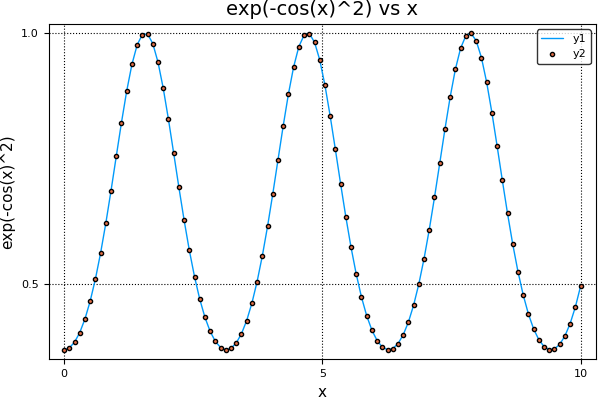

In [17]:
plot(

xlin, Ilin,
xaxis = "x",
yaxis = "exp(-cos(x)^2)",
title = "exp(-cos(x)^2) vs x"

)

scatter!(xlin, Ilin, ms=3.0)

Indeed, since $\cos^2(x)$ oscillates between 0 and 1, $\exp(-\cos^2(x))$ oscillates between 1 and $e^{-1}$ ad infinitum. So yes, we would expect its definite integral to diverge linearly as $x\to\infty$.